# Clustering

Here, we show how SuperSCC conducts heirarchical clustering, wherby cell identity and makers heirarchy could be constrcuted, benefiting to dig scRNAseq data in a finer resolution. 

In [1]:
import SuperSCC as scc
from os.path import basename
import scanpy as sc
import pandas as pd
import numpy as np

In [3]:
file_path =  "/mnt/disk5/zhongmin/superscc/师兄整理的肺数据/未去批次效应couns数据/没有去除批次效应_Banovich_Kropski_2020数据.csv"  

In [4]:
data = pd.read_csv(file_path, index_col=0)
data.head(5)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000283052,ENSG00000283063,ENSG00000283064,ENSG00000283071,ENSG00000283075,ENSG00000283078,ENSG00000283103,ENSG00000283117,ENSG00000283118,ENSG00000283125
ACGGCCACAATGTAAG_F02611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACATGGTGTCTAGCGC_HD66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACGCCGACAATTGCTG_HD68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CTTAACTTCATAAAGG_F02992,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GGCGACTCATCTCCCA_HD67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Since SuperSCC requires log-normalized expression matrix as input, we need to use `Scanpy` to log normalize the raw expression matrix. Otherwise, if data is already log normalized, it could be directly fed to SuperSCC. Here we do the log-normalization step because the data is raw counts matrix.

In [6]:
adata = sc.AnnData(data) # convert dataframe into AnnData object

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

data = pd.DataFrame(np.array(adata.X)) # convert AnnData object back to data frame required by SuperSCC
data.index = adata.obs_names
data.columns = adata.var_names

In [9]:
filename = basename(file_path) # get the filename
my_logger = scc.log_file(f"consensus_{filename}", "w") # construct logging object

# get clustering under M level
global_consensus = scc.global_consensus_cluster(
                        data = data.copy(),
                        n_components = 30,
                        resolution = 1,
                        only_positive = True,
                        cut_off = 0.1,
                        class_weight = "balanced", 
                        n_jobs = -1,
                        logger = my_logger,
                        save = True, 
                        variance_threshold = "mean",
                        n_features_to_select = 0.15,
                        model = "svm",
                        file_name = filename,
                        mutual_info = False,
                        F_test = True,
                        normalization_method = "Min-Max"
                        )


# get clustering under F level
sub_consensus = scc.sub_consensus_cluster(
                            data.copy(),
                            global_consensus, # clustering under M level is one input for sub_consensus_cluster
                            logger = my_logger,
                            save = True, 
                            resolution = 0.2,
                            ep_cut_off = 1,
                            pct_cut_off = 0.5,
                            variance_threshold = "mean",
                            n_features_to_select = 0.15,
                            model = "svm",
                            file_name = filename,
                            n_neighbors = 100, 
                            mutual_info = False,
                            F_test = True,
                            n_jobs = -1,
                            normalization_method = "Min-Max"
                            )


In [5]:
# load F/M clustering 
global_consensus = pd.read_pickle("/mnt/disk5/zhongmin/superscc/师兄整理的肺数据/结果/Banovich_Kropski_2020/2025-02-07/task3/consensus_cluster_result_没有去除批次效应_Banovich_Kropski_2020数据.csv_2025-02-07 17:13:59.pkl")

sub_consensus = pd.read_pickle("/mnt/disk5/zhongmin/superscc/师兄整理的肺数据/结果/Banovich_Kropski_2020/2025-02-07/task3/sub_consensus_cluster_result_没有去除批次效应_Banovich_Kropski_2020数据.csv_2025-02-07 18:03:35.pkl")

The output clustering from global_consenssus (M level) includes five sections: `global_features_before_merging` containing the highly variable genes for the whole dataset before cluster merging, `global_sign_features_before_merging` or `global_sign_features_after_merging` containing the markers of each cluster before/after cluster merging, and `global_cluster_before_merging` or `global_cluster_after_merging` containing the clusterings before/after cluster merging.

In [15]:
global_consensus.keys()

dict_keys(['global_features_before_merging', 'global_sign_features_before_merging', 'global_cluster_before_merging', 'global_sign_features_after_merging', 'global_cluster_after_merging'])

The output clustering from sub_consenssus (F level) includes seven sections: `sub_cluster` containing the clusterings before cluster merging, `sub_sign_features_before_merging` or `sub_sign_features_after_merging` containing the markers of each cluster before/after cluster merging, and `merge_labels` containing the recode labels after cluster merging, `merge_candidates` containing the members be or not be merged, `label_encoder` containing a LabelEncoder object for recoding labels after cluster megring and `neighbors` containg the potential neighborhoods considered being merged for each cluster.

In [42]:
sub_consensus.keys()

dict_keys(['sub_cluster', 'sub_sign_genes_after_merging', 'sub_sign_genes_before_merging', 'neighbors', 'merge_labels', 'merge_candidates', 'label_encoder'])

We show the M/F clustering and ground truth cell type labels below:

In [8]:
# read the meta data
metadata = pd.read_csv("/mnt/disk5/zhongmin/superscc/师兄整理的肺数据/未去批次效应数据/没有去除批次效应_Banovich_Kropski_2020数据metadata.csv", index_col=0)

In [7]:
# do standard scanpy pipeline
sc.pp.highly_variable_genes(adata, n_top_genes = 3000)
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs = 30)
sc.tl.umap(adata)

/home/fengtang/anaconda3/envs/SuperSCC/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# add M/F clustering into AnnData object
adata.obs.loc[:, "clusters_before_cluster_mergeing_under_M_clustering"] = global_consensus["global_cluster_before_merging"]
adata.obs.loc[:, "clusters_after_cluster_mergeing_under_M_clustering"] = global_consensus["global_cluster_after_merging"]["merge_label"]

adata.obs.loc[:, "clusters_after_cluster_mergeing_under_F_clustering"] = [sub_consensus["label_encoder"].classes_[i] for i in sub_consensus["merge_labels"]]

# add groud truth labels under different resolution
adata.obs.loc[:, "coarse_label"] = metadata.loc[:, "ann_level_2"].tolist()
adata.obs.loc[:, "finest_label"] = metadata.loc[:, "ann_finest_level"].tolist()


/tmp/ipykernel_3941583/311754443.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Airway epithelium', 'Alveolar epithelium', 'Lymphoid', 'Myeloid', 'Lymphoid', 'Lymphoid', 'Myeloid', 'Blood vessels', 'Myeloid', 'Myeloid', 'Airway epithelium', 'Alveolar epithelium', 'Alveolar epithelium', 'Myeloid', 'Blood vessels', 'Myeloid', 'Myeloid', 'Myeloid', 'Airway epithelium', 'Lymphoid', 'Airway epithelium', 'Myeloid', 'Myeloid', 'Lymphoid', 'Myeloid', 'Myeloid', 'Blood vessels', 'Airway epithelium', 'Airway epithelium', 'Alveolar epithelium', 'Alveolar epithelium', 'Myeloid', 'Myeloid', 'Myeloid', 'Alveolar epithelium', 'Lymphoid', 'Lymphatic EC', 'Myeloid', 'Alveolar epithelium', 'Lymphoid', 'Fibroblast lineage', 'Myeloid', 'Alveolar epithelium', 'Fibroblast lineage', 'Myeloid', 'Lymphoid', 'Lymphoid', 'Lymphatic EC', 'Myeloid', 'Alveolar epithelium', 'Alveolar epithelium', 'Fibroblast lineage', 'Airway epithelium',

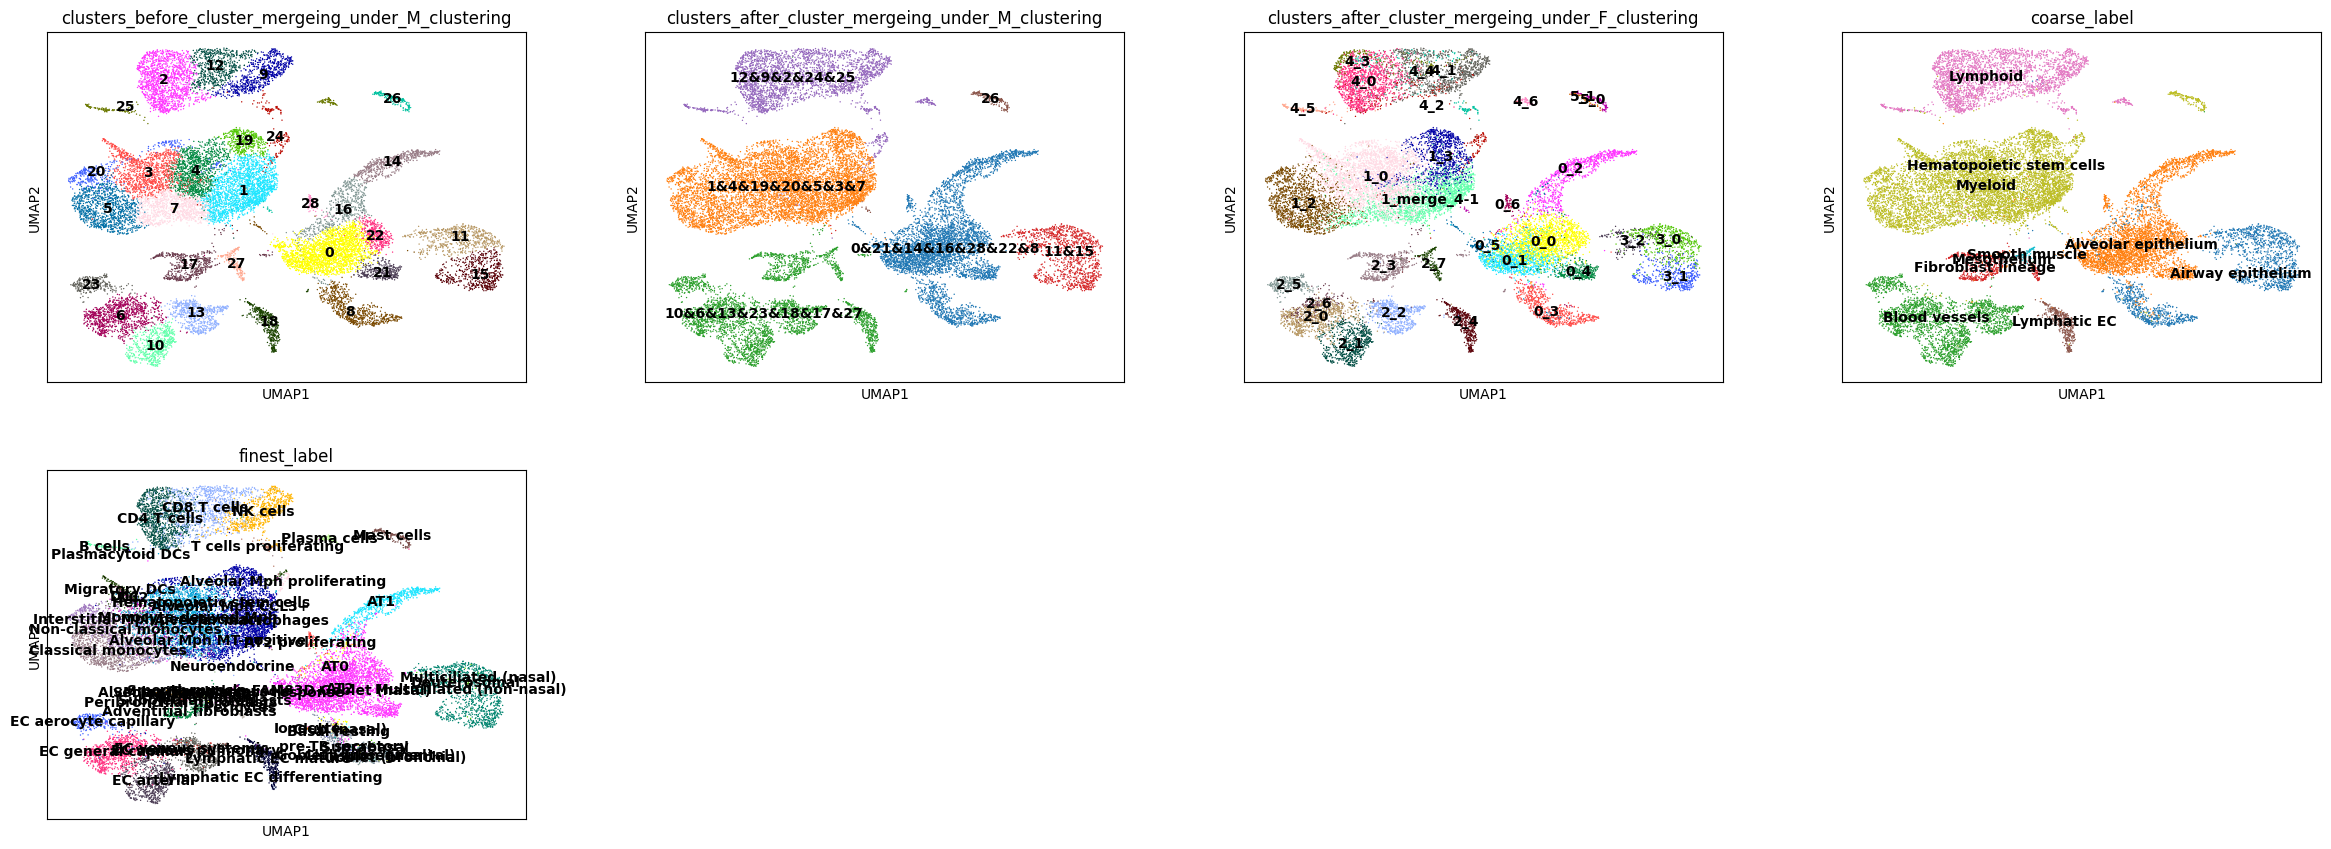

In [14]:
sc.pl.umap(
    adata,
    color = ["clusters_before_cluster_mergeing_under_M_clustering",
             "clusters_after_cluster_mergeing_under_M_clustering",
             "clusters_after_cluster_mergeing_under_F_clustering",
             "coarse_label",
             "finest_label"],
    size = 4,
    legend_loc = "on data"
)

Obviously, M clustering can correctly match the broad ground truth cell type labels, while F clustering exceeds the number of finest cell type labels, which may provide a finder biological clues (such as rare cell population) that would be discussed in our manuscript.